PPG_valley: 6
PPG_peak: 6
dPPG_peak: 6
dPPG_valley: 6
sdPPG_a: 6
sdPPG_b: 6
TD(PPG_valley-sdPPG_d): -0.662
PW_50%: 0.354
PW_60%: 0.28
PW_70%: 0.22799999999999998
AA(PPG_valley-sdPPG_d): 1.4408200663999426
AI_PPG(sdPPG_b): 0.3980909889924955
AI_dPPG(peak): 11.497733901672555
AI_sdPPG(a): 477.60078369053963
AR(Cycle): 0.012595674882217477
RI(sdPPG_c+d-b/a): 1.0


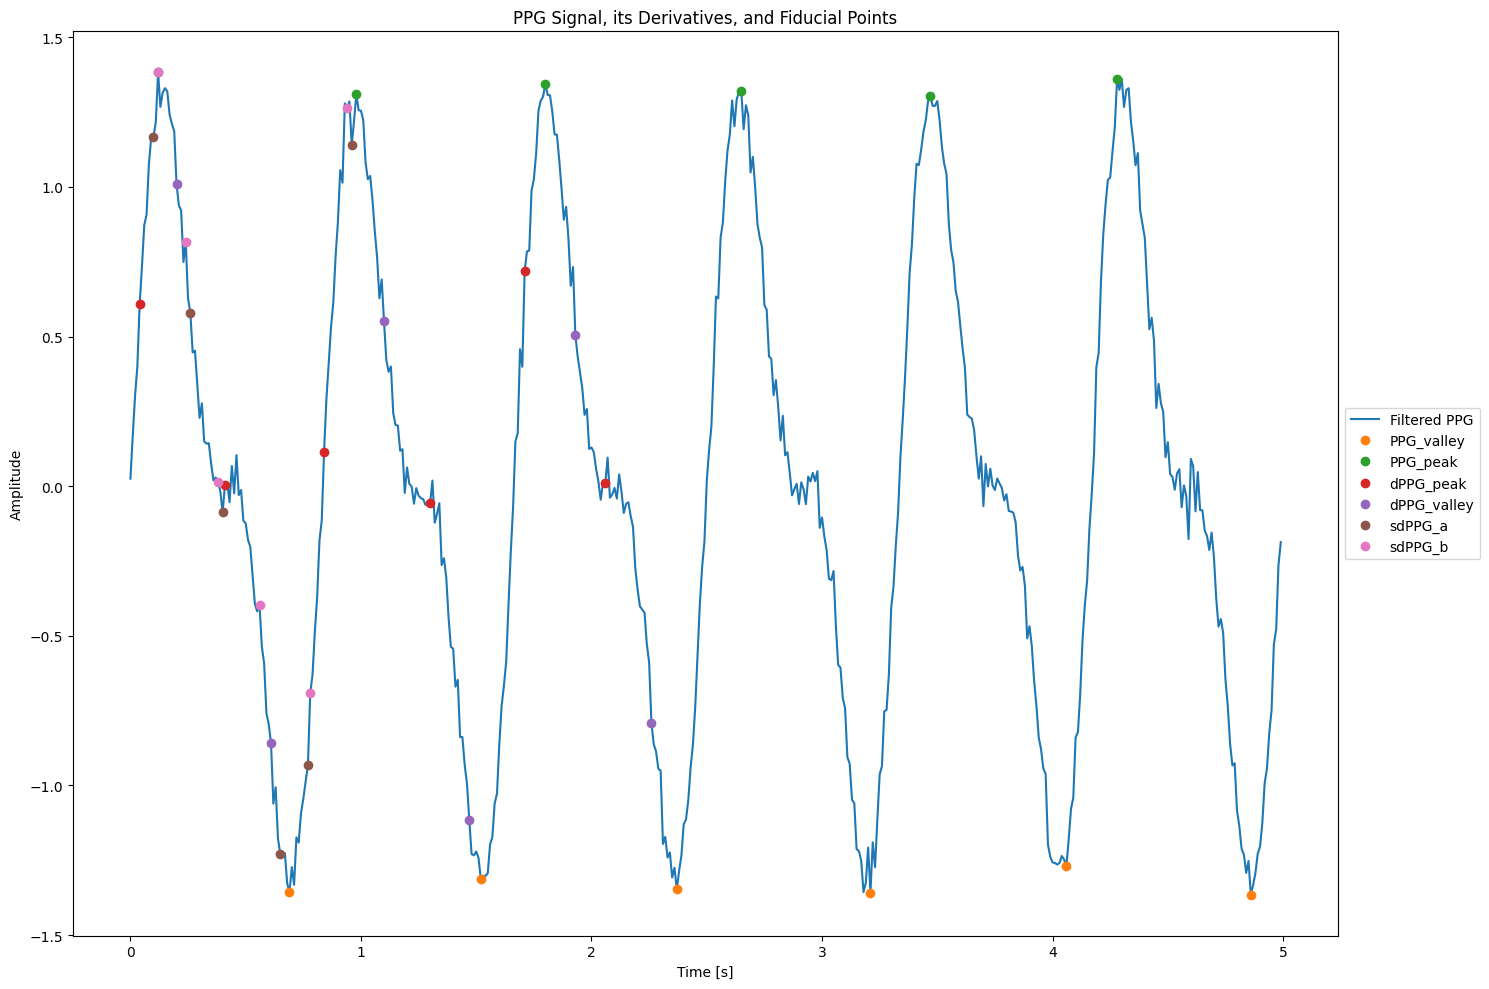

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

def create_toy_ppg(duration=5, fs=100):
    t = np.linspace(0, duration, int(duration * fs), endpoint=False)
    ppg = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 2.4 * t)
    ppg = ppg + np.random.normal(0, 0.05, ppg.shape)
    return ppg

# Create and process the toy PPG signal
fs = 100
ppg_signal = create_toy_ppg(duration=5, fs=fs)
t = np.linspace(0, 5, len(ppg_signal), endpoint=False)

# 전처리: 밴드패스 필터 적용
def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# filtered_ppg = bandpass_filter(ppg_signal, 0.5, 8, fs)
filtered_ppg = ppg_signal

# PPG의 1차, 2차 미분
dPPG = np.gradient(filtered_ppg, 1/fs)
sdPPG = np.gradient(dPPG, 1/fs)

# 개선된 기준점 검출 함수
def find_fiducial_points(ppg, dppg, sdppg):
    ppg_peaks, _ = find_peaks(ppg, distance=fs//2, prominence=0.1)
    ppg_valleys, _ = find_peaks(-ppg, distance=fs//2, prominence=0.1)
    
    dppg_peaks, _ = find_peaks(dppg, distance=fs//4)
    dppg_valleys, _ = find_peaks(-dppg, distance=fs//4)
    
    sdppg_peaks, _ = find_peaks(sdppg, distance=fs//8)
    sdppg_valleys, _ = find_peaks(-sdppg, distance=fs//8)
    
    FP = {
        'PPG_valley': ppg_valleys,
        'PPG_peak': ppg_peaks,
        'dPPG_peak': dppg_peaks,
        'dPPG_valley': dppg_valleys,
        'sdPPG_a': sdppg_peaks,
        'sdPPG_b': sdppg_valleys,
    }
    
    # Ensure all arrays have the same length
    min_len = min(len(v) for v in FP.values())
    return {k: v[:min_len] for k, v in FP.items()}

FP = find_fiducial_points(filtered_ppg, dPPG, sdPPG)

# 각 기준점의 길이 출력
for key, value in FP.items():
    print(f"{key}: {len(value)}")

# 특징 추출 함수들
def time_duration(fp1, fp2):
    return np.mean(np.diff(fp2) - np.diff(fp1)) / fs if len(fp1) > 1 and len(fp2) > 1 else np.nan

def pulse_width(signal, peaks, valleys, percentage):
    if len(peaks) == 0 or len(valleys) == 0:
        return np.nan
    
    widths = []
    for i, peak in enumerate(peaks):
        # 현재 피크 이전의 가장 가까운 골짜기 찾기
        prev_valley = valleys[valleys < peak][-1] if any(valleys < peak) else None
        # 현재 피크 이후의 가장 가까운 골짜기 찾기
        next_valley = valleys[valleys > peak][0] if any(valleys > peak) else None
        
        if prev_valley is not None and next_valley is not None:
            # 임계값 계산
            threshold = percentage * (signal[peak] - signal[prev_valley]) + signal[prev_valley]
            
            # 왼쪽 교차점 찾기
            left_cross = np.where(signal[prev_valley:peak] >= threshold)[0]
            if len(left_cross) > 0:
                left_cross = left_cross[0] + prev_valley
            else:
                continue
            
            # 오른쪽 교차점 찾기
            right_cross = np.where(signal[peak:next_valley] <= threshold)[0]
            if len(right_cross) > 0:
                right_cross = right_cross[0] + peak
            else:
                continue
            
            # 펄스 폭 계산
            width = (right_cross - left_cross) / fs
            widths.append(width)
    
    return np.mean(widths) if widths else np.nan

def amplitude_alteration(signal, fp1, fp2):
    return np.mean(signal[fp2] - signal[fp1])

def absolute_intensity(signal, fp):
    return np.mean(signal[fp])

def area_under_curve(signal, start, end):
    return np.mean([np.trapz(signal[s:e], dx=1/fs) for s, e in zip(start[:-1], end[1:])])

def calculate_ri(sdPPG, c, d, b, a):
    return np.mean((sdPPG[c] + sdPPG[d] - sdPPG[b]) / sdPPG[a])

# 특징 추출
features = {
    "TD(PPG_valley-sdPPG_d)": time_duration(FP['PPG_valley'], FP['sdPPG_a']),
    "PW_50%": pulse_width(filtered_ppg, FP['PPG_peak'], FP['PPG_valley'], 0.5),
    "PW_60%": pulse_width(filtered_ppg, FP['PPG_peak'], FP['PPG_valley'], 0.6),
    "PW_70%": pulse_width(filtered_ppg, FP['PPG_peak'], FP['PPG_valley'], 0.7),
    "AA(PPG_valley-sdPPG_d)": amplitude_alteration(filtered_ppg, FP['PPG_valley'], FP['sdPPG_a']),
    "AI_PPG(sdPPG_b)": absolute_intensity(filtered_ppg, FP['sdPPG_b']),
    "AI_dPPG(peak)": absolute_intensity(dPPG, FP['dPPG_peak']),
    "AI_sdPPG(a)": absolute_intensity(sdPPG, FP['sdPPG_a']),
    "AR(Cycle)": area_under_curve(filtered_ppg, FP['PPG_valley'], FP['PPG_valley']),
    "RI(sdPPG_c+d-b/a)": calculate_ri(sdPPG, FP['sdPPG_a'], FP['sdPPG_b'], FP['sdPPG_b'], FP['sdPPG_a'])
}

# 결과 출력
for key, value in features.items():
    print(f"{key}: {value}")

# PPG 신호와 기준점 시각화
plt.figure(figsize=(15, 10))
plt.plot(t, filtered_ppg, label='Filtered PPG')
# plt.plot(t, dPPG, label='First Derivative of PPG')
# plt.plot(t, sdPPG, label='Second Derivative of PPG')
for key, fp in FP.items():
    plt.plot(t[fp], filtered_ppg[fp], 'o', label=key)
plt.title('PPG Signal, its Derivatives, and Fiducial Points')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

{'Time Duration (TD) [s]': 0.836, 'Pulse Widths (sec)': 0.21999999999999997, 'Amplitude Alteration': 2.1845007652910935, 'Area': 0.004621626858352566, 'Relative Index': 0.99070914964018}


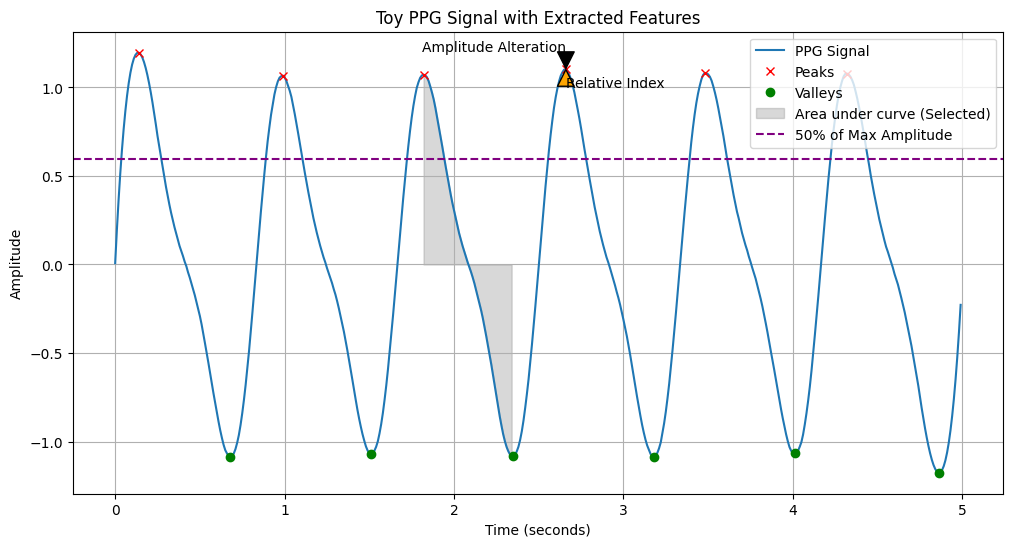

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter, argrelextrema
from scipy.integrate import simps

def create_toy_ppg(duration=5, fs=100):
    t = np.linspace(0, duration, int(duration * fs), endpoint=False)
    ppg = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 2.4 * t)
    ppg += np.random.normal(0, 0.05, len(t))
    return ppg, t

def preprocess_signal(ppg_signal, window_length, polyorder):
    # Apply Savitzky-Golay filter to smooth the signal
    filtered_signal = savgol_filter(ppg_signal, window_length=window_length, polyorder=polyorder)
    return filtered_signal

def extract_features(ppg_signal, fs):
    ppg_signal = preprocess_signal(ppg_signal, window_length=51, polyorder=3)
    peaks, _ = find_peaks(ppg_signal, distance=fs*0.5)
    valleys, _ = find_peaks(-ppg_signal, distance=fs*0.5)

    if len(peaks) < 2 or len(valleys) < 1:
        print("Insufficient number of peaks or valleys detected.")
        return None

    # Time Duration (TD)
    TD = np.diff(peaks) / fs

    # Pulse Width at 50% of max amplitude
    half_max = np.max(ppg_signal[peaks]) / 2
    crossings = np.where(np.diff(ppg_signal > half_max))[0]
    pulse_widths = np.diff(crossings)[::2] / fs  # time in seconds

    # Amplitude Alteration and Area using middle peak and valley
    middle_peak_index = len(peaks) // 2
    middle_valley_index = np.searchsorted(valleys, peaks[middle_peak_index]) - 1

    amplitude_alteration = np.abs(ppg_signal[peaks[middle_peak_index]] - ppg_signal[valleys[middle_valley_index]])
    
    if valleys[middle_valley_index] > peaks[middle_peak_index - 1]:
        area = simps(ppg_signal[peaks[middle_peak_index - 1]:valleys[middle_valley_index]], dx=1/fs)
    else:
        area = simps(ppg_signal[valleys[middle_valley_index]:peaks[middle_peak_index]], dx=1/fs)

    # Relative Index
    # 모든 피크 진폭의 평균을 사용하는 경우
    relative_index = ppg_signal[peaks[middle_peak_index]] / np.mean(ppg_signal[peaks])
    

    return {
        'Time Duration (TD) [s]': np.mean(TD),
        'Pulse Widths (sec)': np.mean(pulse_widths),
        'Amplitude Alteration': amplitude_alteration,
        'Area': area,
        'Relative Index': relative_index
    }

def plot_features(ppg_signal, t, features, fs):
    plt.figure(figsize=(12, 6))
    plt.plot(t, ppg_signal, label='PPG Signal')
    peaks, _ = find_peaks(ppg_signal, distance=fs*0.5)
    valleys, _ = find_peaks(-ppg_signal, distance=fs*0.5)

    plt.plot(t[peaks], ppg_signal[peaks], 'rx', label='Peaks')
    plt.plot(t[valleys], ppg_signal[valleys], 'go', label='Valleys')

    # Plot area for Amplitude Alteration and Area calculation
    middle_peak_index = len(peaks) // 2
    middle_valley_index = np.searchsorted(valleys, peaks[middle_peak_index]) - 1
    plt.fill_between(t[peaks[middle_peak_index - 1]:valleys[middle_valley_index]], ppg_signal[peaks[middle_peak_index - 1]:valleys[middle_valley_index]], color='gray', alpha=0.3, label='Area under curve (Selected)')

    # Show Pulse Width at 50%
    half_max = np.max(ppg_signal[peaks]) / 2
    plt.axhline(y=half_max, color='purple', linestyle='--', label='50% of Max Amplitude')

    # Annotate features
    plt.annotate('Amplitude Alteration', xy=(t[peaks[middle_peak_index]], ppg_signal[peaks[middle_peak_index]]),
                 xytext=(t[peaks[middle_peak_index]], ppg_signal[peaks[middle_peak_index]] + 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right')

    plt.annotate('Relative Index', xy=(t[peaks[middle_peak_index]], ppg_signal[peaks[middle_peak_index]]),
                 xytext=(t[peaks[middle_peak_index]], ppg_signal[peaks[middle_peak_index]] - 0.1),
                 arrowprops=dict(facecolor='orange', shrink=0.05), horizontalalignment='left')

    plt.title('Toy PPG Signal with Extracted Features')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create and process the toy PPG signal
fs = 100
ppg_signal, t = create_toy_ppg(duration=5, fs=fs)
# Preprocess the signal

# Extract and print features
features = extract_features(ppg_signal, fs)
if features:
    print(features)
    plot_features(filtered_ppg, t, features, fs)
